In [1]:
%matplotlib inline
import vtk
import dicom
import os
import numpy as np
from matplotlib import pyplot as plt, cm
from IPython.display import Image
from skxray.io import vtk_tools
import skxray

In [2]:
def vtk_show(renderer, width=None, height=None):
    """
    Converts a vtkRenderer object into an iPython image
    
    Note: This method generates an external window within which 
    rendering actually occurs. The generated image is then returned 
    to the ipython session.
    
    Ref: https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/
    """
    if width == None:
        width = 400
    if height == None:
        height=300
    
    renderWindow = vtk.vtkRenderWindow() #Create new rendering window
    renderWindow.SetOffScreenRendering(1) #Enable off-screen rendering
    renderWindow.AddRenderer(renderer) #Create instance
    renderWindow.SetSize(width, height) #Set Dims
    renderWindow.Render() #Execute render operation
    
    windowToImageFilter = vtk.vtkWindowToImageFilter() #Create a new vtkWindow -> Image filter object which allows us to read teh data in a vtkWindow and use it as input to the imaging pipeline.
    windowToImageFilter.SetInput(renderWindow) #Add renderWindow to the filter object
    windowToImageFilter.Update() #Update object
    
    writer = vtk.vtkPNGWriter() #Create vtk PNG writer object thereby allowing creation of PNG images of the vtkWindow rendering
    writer.SetWriteToMemory(1) #Setting eq to 1 enables image to be held in memory instead of saving to disk. This is the desired option since the image is meant to be loaded back into the notebook instead of stored on disk
    writer.SetInputConnection(windowToImageFilter.GetOutputPort()) # Link between output (GetOutputPort) of vtkWindowToImageFilter and the PNG writer (SetInputConnection)
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

In [3]:
specimen_list = ['human_male', 'human_female']
human_male_dsets = ['Head', 'Hip', 'Pelvis', 'Shoulder']
human_female_dsets = ['Ankle', 'Head', 'Hip', 'Knee', 'Pelvis', 'Shoulder']

img_path = '../data/CT/human_male/Head/'
dcm_file_list = []
for dirName, subdirList, fileList in os.walk(img_path):
    for filename in fileList:
        if ".dcm" in filename.lower():
            dcm_file_list.append(os.path.join(dirName, filename))
dcm_file_list.sort()


In [4]:
ref_dims = dicom.read_file(dcm_file_list[0])

In [5]:
pixel_dims = (int(ref_dims.Rows), int(ref_dims.Columns), len(dcm_file_list))
print pixel_dims

(512, 512, 245)


In [6]:
pixel_spacing = (float(ref_dims.PixelSpacing[0]), float(ref_dims.PixelSpacing[1]), float(ref_dims.SliceThickness))
print pixel_spacing


(1.0, 1.0, 1.0)


In [7]:
#Calculate axis dimensions using metadata from the dicom files.
x_dim = np.arange(0.0, (pixel_dims[0]+1)*pixel_spacing[0], pixel_spacing[0])
y_dim = np.arange(0.0, (pixel_dims[1]+1)*pixel_spacing[1], pixel_spacing[1])
z_dim = np.arange(0.0, (pixel_dims[2]+1)*pixel_spacing[2], pixel_spacing[2])


In [8]:
#Create empty array to which image data will be added
image_array = np.zeros(pixel_dims, dtype=ref_dims.pixel_array.dtype)

print ref_dims.pixel_array.dtype
print image_array.dtype

int16
int16


In [9]:
#Hounsfield intensity conversion constants
print 'Recorded intensity conversion constants:'
print 'Calibration Slope: ' + str(ref_dims.RescaleSlope)
print 'Calibration Intercept: ' + str(ref_dims.RescaleIntercept)

Recorded intensity conversion constants:
Calibration Slope: 1
Calibration Intercept: -1024


In [10]:
#Loop through all dicom files and generate the 3D image array
for filename in dcm_file_list:
    #read file
    raw_data = dicom.read_file(filename)
    #add file to image array
    image_array[:,:, dcm_file_list.index(filename)] = ref_dims.RescaleSlope * raw_data.pixel_array + ref_dims.RescaleIntercept


### Note that the pixel_array object is a pure numpy array containing the actual image data

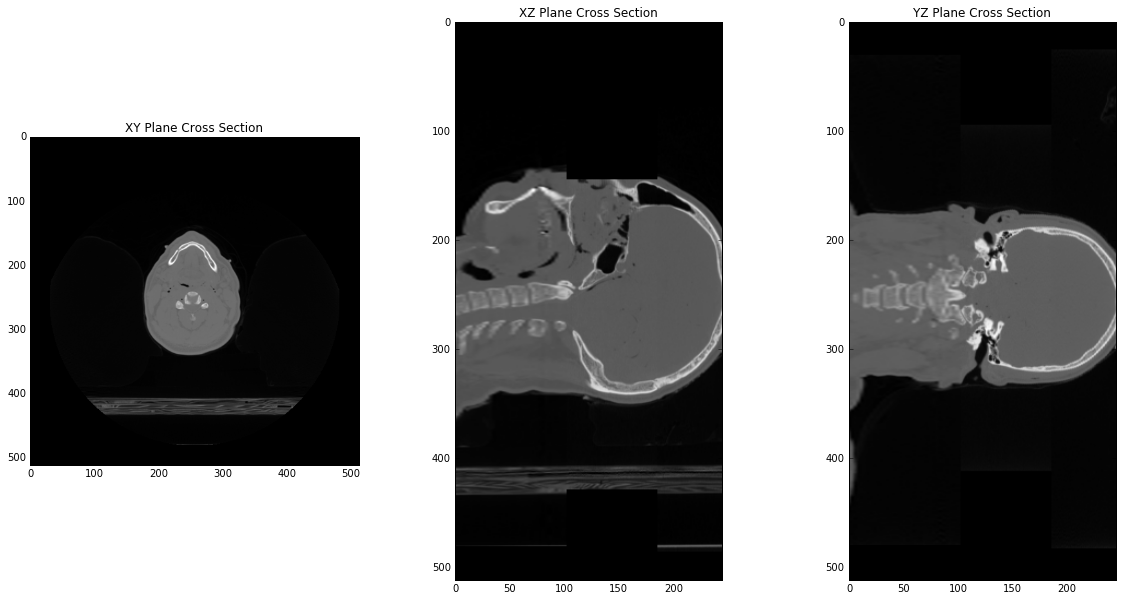

In [11]:
#Cross sectional orthoslices of the dataset
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('XY Plane Cross Section')
plt.imshow(image_array[:,:,50], cmap=plt.cm.gray)

plt.subplot(132)
plt.title('XZ Plane Cross Section')
plt.imshow(image_array[:,250, :], cmap=plt.cm.gray)

plt.subplot(133)
plt.title('YZ Plane Cross Section')
plt.imshow(image_array[250, :,:], plt.cm.gray)

plt.show()

In [12]:
print 'Image constants: array dimensions -- ' + str(image_array.shape)
print 'Image constants: data type -- ' + str(image_array.dtype)
print 'Image constants: max value -- ' + str(np.amax(image_array))
print 'Image constants: min value -- ' + str(np.amin(image_array))

Image constants: array dimensions -- (512, 512, 245)
Image constants: data type -- int16
Image constants: max value -- 3617
Image constants: min value -- -1024


1000
1000


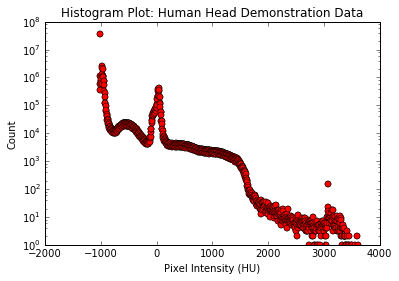

In [18]:
from skxray.core.image import hist_make
bin_count, bin_edges, bin_avg = hist_make(image_array, 1000)
print len(bin_count)
print len(bin_avg)
plt.plot(bin_avg, bin_count, 'ro')
plt.yscale('log')
plt.title('Histogram Plot: Human Head Demonstration Data')
plt.xlabel('Pixel Intensity (HU)')
plt.ylabel('Count')
plt.show()

### Object Conversion: Numpy array to VTK object

In [14]:
dataImporter = vtk.vtkImageImport()
_NP_TO_VTK_dTYPE_DICT = {
        'bool' : dataImporter.SetDataScalarTypeToUnsignedChar(),
        'character' : dataImporter.SetDataScalarTypeToUnsignedChar(),
        'uint8' : dataImporter.SetDataScalarTypeToUnsignedChar(),
        'uint16' : dataImporter.SetDataScalarTypeToUnsignedShort(),
        'uint32' : dataImporter.SetDataScalarTypeToInt(),
        'uint64' : dataImporter.SetDataScalarTypeToInt(),
        'int8' : dataImporter.SetDataScalarTypeToShort(),
        'int16' : dataImporter.SetDataScalarTypeToShort(),
        'int32' : dataImporter.SetDataScalarTypeToInt(),
        'int64' : dataImporter.SetDataScalarTypeToInt(),
        'float32' : dataImporter.SetDataScalarTypeToFloat(),
        'float64' : dataImporter.SetDataScalarTypeToDouble(),
        }


In [19]:
#vtk_data = vtk_tools.np_to_vtk(image_array, pixel_spacing)
from vtk.util.numpy_support import *

In [20]:
vol = vtk.vtkImageData()
vol.SetDimensions(image_array.shape[0], image_array.shape[1], image_array.shape[2])
vol.SetOrigin(0,0,0)
vol.SetSpacing(1,1,1)

vtk_data = numpy_to_vtk(image_array.ravel(), deep=True)

vol.GetPointData().SetScalars(vtk_data)

0

In [22]:
opacity_xfer_func = vtk.vtkPiecewiseFunction()
opacity_xfer_func.AddPoint()

TypeError: no overloads of AddPoint() take 0 arguments

In [23]:
vtk_data.GetDataTypeValueMin()

-32768

In [16]:
z_dim, y_dim, x_dim = image_array.shape
_NP_TO_VTK_dTYPE_DICT[str(image_array.dtype)]
#help(dataImporter.SetInput)
#dataImporter.SetInput(vtk_data)
#dataImporter.SetDataScalarTypeToShort()
dataImporter.SetNumberOfScalarComponents(1)
dataImporter.SetDataExtent(0, x_dim-1, 0, y_dim-1, 0, z_dim-1)
dataImporter.SetWholeExtent(0, x_dim-1, 0, y_dim-1, 0, z_dim-1)
dataImporter.SetDataSpacing(pixel_spacing[0], pixel_spacing[1], pixel_spacing[2])
img_string = image_array.tostring()
dataImporter.CopyImportVoidPointer(img_string, len(img_string))

In [17]:
dataImporter.GetOutputPort()

(vtkAlgorithmOutput)0x7fe7fd1d6410

In [25]:
threshold_np = vtk.vtkImageThreshold()
threshold_np.SetInputDataObject(vol)
threshold_np.ThresholdByLower(450)
threshold_np.ReplaceInOn()
threshold_np.SetInValue(0)
threshold_np.ReplaceOutOn()
threshold_np.SetOutValue(1)
threshold_np.Update()

In [29]:
img_object = vtk.vtkImageData()
img_object.SetOrigin(0,0,0)
img_object.SetSpacing(pixel_spacing)
img_object.SetDimensions(pixel_dims)
img_object.SetScalarType(vtk_data.GetDataType())
help(img_object.GetArrayPointer)
img_object.GetArrayPointer(vtk_data, [512, 512, 245])

TypeError: SetScalarType() takes exactly 2 arguments (1 given)

In [19]:
help(img_object.GetAttributes)


Help on built-in function GetAttributes:

GetAttributes(...)
    V.GetAttributes(int) -> vtkDataSetAttributes
    C++: virtual vtkDataSetAttributes *GetAttributes(int type)
    
    Returns the attributes of the data object of the specified
    attribute type. The type may be:  POINT  - Defined in vtkDataSet
    subclasses. CELL   - Defined in vtkDataSet subclasses. VERTEX -
    Defined in vtkGraph subclasses. EDGE   - Defined in vtkGraph
    subclasses. ROW    - Defined in vtkTable.  The other attribute
    type, FIELD, will return NULL since field data is stored as a
    vtkFieldData instance, not a vtkDataSetAttributes instance. To
    retrieve field data, use GetAttributesAsFieldData.



In [20]:
img_object.GetScalarTypeAsString()

'short'

In [21]:
array = img_object.GetPointData()

In [22]:
print array

vtkPointData (0x40d2120)
  Debug: Off
  Modified Time: 14
  Reference Count: 2
  Registered Events: (none)
  Number Of Arrays: 0
  Number Of Components: 0
  Number Of Tuples: 0
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)




In [36]:
help(img_object.GetAttributes)
tmp = img_object.GetAttributes(img_object.POINT)


Help on built-in function GetAttributes:

GetAttributes(...)
    V.GetAttributes(int) -> vtkDataSetAttributes
    C++: virtual vtkDataSetAttributes *GetAttributes(int type)
    
    Returns the attributes of the data object of the specified
    attribute type. The type may be:  POINT  - Defined in vtkDataSet
    subclasses. CELL   - Defined in vtkDataSet subclasses. VERTEX -
    Defined in vtkGraph subclasses. EDGE   - Defined in vtkGraph
    subclasses. ROW    - Defined in vtkTable.  The other attribute
    type, FIELD, will return NULL since field data is stored as a
    vtkFieldData instance, not a vtkDataSetAttributes instance. To
    retrieve field data, use GetAttributesAsFieldData.



In [38]:
print tmp

vtkPointData (0x40d2120)
  Debug: Off
  Modified Time: 14
  Reference Count: 2
  Registered Events: (none)
  Number Of Arrays: 0
  Number Of Components: 0
  Number Of Tuples: 0
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)




In [ ]:
threshold_np = vtk.vtkImageThreshold()
threshold_np.SetInputConnection(vtk_data.GetOutputPort())
threshold_np.ThresholdByLower(450)
threshold_np.ReplaceInOn()
threshold_np.SetInValue(0)
threshold_np.ReplaceOutOn()
threshold_np.SetOutValue(1)
threshold_np.Update()

### File compilation directly using VTK. For comparison of data types and error checking to see why my converted data fails.

In [56]:
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(img_path)
reader.Update()
print img_path

../data/CT/human_male/Head/


In [34]:
_extent = reader.GetDataExtent()
_extent

(0, 511, 0, 511, 0, 244)

In [35]:
pixel_dims_vtk = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
pixel_spacing_vtk = reader.GetPixelSpacing()

In [36]:
print pixel_dims_vtk
print pixel_spacing_vtk

[512, 512, 245]
(1.0, 1.0, 1.0)


In [41]:
help(reader.GetOutput())

Help on vtkobject object:

class vtkobject(object)
 |  Use help(x.__class__) to get full documentation.
 |  
 |  Methods defined here:
 |  
 |  __delattr__(...)
 |      x.__delattr__('name') <==> del x.name
 |  
 |  __getattribute__(...)
 |      x.__getattribute__('name') <==> x.name
 |  
 |  __repr__(...)
 |      x.__repr__() <==> repr(x)
 |  
 |  __setattr__(...)
 |      x.__setattr__('name', value) <==> x.name = value
 |  
 |  __str__(...)
 |      x.__str__() <==> str(x)



In [42]:
tmp = reader.GetOutput()

In [43]:
help(tmp)

Help on vtkobject object:

class vtkobject(object)
 |  Use help(x.__class__) to get full documentation.
 |  
 |  Methods defined here:
 |  
 |  __delattr__(...)
 |      x.__delattr__('name') <==> del x.name
 |  
 |  __getattribute__(...)
 |      x.__getattribute__('name') <==> x.name
 |  
 |  __repr__(...)
 |      x.__repr__() <==> repr(x)
 |  
 |  __setattr__(...)
 |      x.__setattr__('name', value) <==> x.name = value
 |  
 |  __str__(...)
 |      x.__str__() <==> str(x)



In [48]:
help(tmp.GetDimensions)
tmp.GetDimensions()

Help on built-in function GetDimensions:

GetDimensions(...)
    V.GetDimensions() -> (int, int, int)
    C++: virtual int *GetDimensions()
    V.GetDimensions([int, int, int])
    C++: virtual void GetDimensions(int dims[3])
    
    Get dimensions of this structured points dataset. It is the
    number of points on each axis. Dimensions are computed from
    Extents during this call.



(512, 512, 245)

In [49]:
vol.GetDimensions()

(512, 512, 245)

In [40]:
help(vol)

Help on vtkobject object:

class vtkobject(object)
 |  Use help(x.__class__) to get full documentation.
 |  
 |  Methods defined here:
 |  
 |  __delattr__(...)
 |      x.__delattr__('name') <==> del x.name
 |  
 |  __getattribute__(...)
 |      x.__getattribute__('name') <==> x.name
 |  
 |  __repr__(...)
 |      x.__repr__() <==> repr(x)
 |  
 |  __setattr__(...)
 |      x.__setattr__('name', value) <==> x.name = value
 |  
 |  __str__(...)
 |      x.__str__() <==> str(x)



In [37]:
reader.GetInput


<function GetInput>

In [53]:
threshold = vtk.vtkImageThreshold()
threshold.SetInputConnection(reader.GetOutputPort())
#threshold.SetInputData(vol)
threshold.ThresholdByLower(450)
threshold.ReplaceInOn()
threshold.SetInValue(0)
threshold.ReplaceOutOn()
threshold.SetOutValue(1)
threshold.Update()

In [54]:
dmc = vtk.vtkDiscreteMarchingCubes()
dmc.SetInputConnection(threshold_np.GetOutputPort())
dmc.GenerateValues(1,1,1)
dmc.Update()

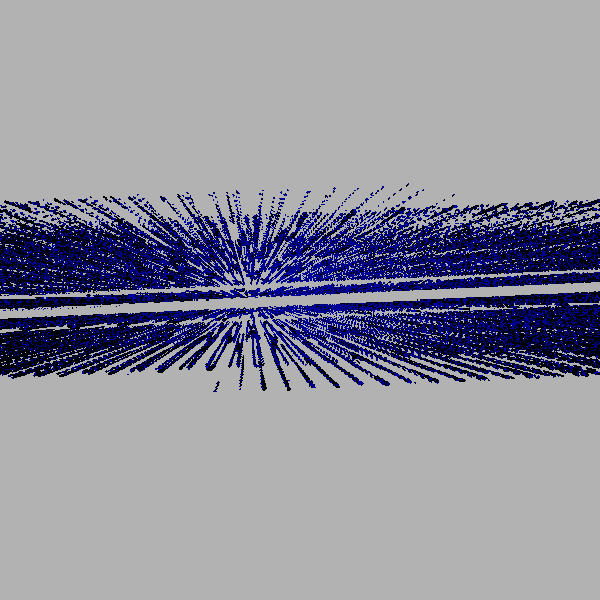

In [55]:
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(dmc.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.7,0.7,0.7)

camera = renderer.MakeCamera()
camera.SetPosition(-500.0, 245.5, 122.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30.0)
camera.SetRoll(-90.0)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 600, 600)

In [26]:
filename = 'tmp_file.stl'

In [27]:
path = '/home/giltis/data/'


In [28]:
filename = path+filename

In [29]:
filename

'/home/giltis/data/tmp_file.stl'